<b>I’m Something of a Painter Myself </b> <br><br>
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For this Kaggle competition, the task is to generate images in the style of Monet. This generator is trained using a discriminator.
The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.
Our objective is to build a GAN that generates 7,000 to 10,000 Monet-style images.  <br>
This dataset was created by Amy Jang, Ana Sofia Uzsoy, Phil Culliton and can be found at https://www.kaggle.com/competitions/gan-getting-started


In [6]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses

In [16]:
# this notebook was run on Google Colab with TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
print(f'REPLICAS: {REPLICAS}')

Running on TPU 


REPLICAS: 8


In [7]:
# set directory paths
BASE_PATH = 'painting'
MONET_PATH = os.path.join(BASE_PATH, 'monet_jpg')
PHOTO_PATH = os.path.join(BASE_PATH, 'photo_jpg')

<b> Exploratory Data Analysis </b><br><br>
This dataset has four directories: <br>
- monet_tfrec<br>
- photo_tfrec<br>
- monet_jpg<br>
- photo_jpg<br>

The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos. The monet directories contain 300 Monet paintings. These images are used to train our model. The photo directories contain ~7000 photos which will be transformed into Monet-style paintings using CycleGAN. Bothe the original paintings and the photos are of size 256 x 256 pixels. Since there's not much else to talk about in terms of EDA, I've just displayed a few of the images so you can see what Monet's paintings look like.


In [8]:
# check image sizes and counts
def show_folder_info(path):
    d_image_sizes = {}
    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        d_image_sizes[image.shape] = d_image_sizes.get(image.shape, 0) + 1

    for size, count in d_image_sizes.items():
        print(f'shape: {size}\tcount: {count}')


print('Monet images:')
show_folder_info(MONET_PATH)

print('Photo images:')
show_folder_info(PHOTO_PATH)

Monet images:
shape: (256, 256, 3)	count: 300
Photo images:
shape: (256, 256, 3)	count: 7038


In [9]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

MONET_FILENAMES = tf.io.gfile.glob(str(BASE_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(BASE_PATH + '/photo_tfrec/*.tfrec'))

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print('Number of Monet TFRecord Files:', len(MONET_FILENAMES))
print('Number of Photo TFRecord Files:', len(PHOTO_FILENAMES))

Number of Monet TFRecord Files: 5
Number of Photo TFRecord Files: 20


In [10]:
# set hyperparameters
BUFFER_SIZE = 1000
BATCH_SIZE =  4
EPOCHS_NUM = 10
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [11]:
# recode a jpg image to a tfrecord file, normalize the image and reshape it
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 3])
    return image

# parse the tfrecord file and decode the image
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image":      tf.io.FixedLenFeature([], tf.string),
        "target":     tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# augment the image the image by rotating, mirroring and adding jitter
def data_augment(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    # jitter
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286])
        image = tf.image.random_crop(image, size=[256, 256, 3])
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, 3])

    # rotate
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1) # rotate 90º

    # mirror
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_spatial > .9:
            image = tf.image.transpose(image)

    return image

In [12]:
# load the dataset from the tfrecord files
AUTOTUNE = tf.data.experimental.AUTOTUNE

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    # map a dataset with a mapping function read_tfrecord and
    # Number of parallel calls is set to AUTOTUNE constant previously defined
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [13]:
# load the monet and photo datasets
BATCHSIZE = 1
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(BATCHSIZE, drop_remainder=True)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(BATCHSIZE, drop_remainder=True)

In [14]:
# load the Monet and Photo datasets, applies the augmentation function if provided, and returns a zipped dataset of Monet and Photo images.
def get_gan_dataset(monet_files, photo_files, augment=None, batch_size=1):

    # load the Monet and Photo datasets
    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)

    # apply provided augment function to the dataset
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTO)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO)

    # repeat the dataset indefinitely to get a continuous stream of data and shuffle the dataset to ensure randomness
    monet_ds = monet_ds.repeat()
    photo_ds = photo_ds.repeat()    
    monet_ds = monet_ds.shuffle(2048)
    photo_ds = photo_ds.shuffle(2048)

    # batch the dataset and drop the remainder to get a fixed batch size, then cache the dataset to memory for better performance
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO)
    photo_ds = photo_ds.prefetch(AUTO)

    ds = tf.data.Dataset.zip((monet_ds, photo_ds))

    return ds

In [17]:
full_dataset = get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, augment=data_augment, repeat=True, shuffle=True, batch_size=BATCH_SIZE)

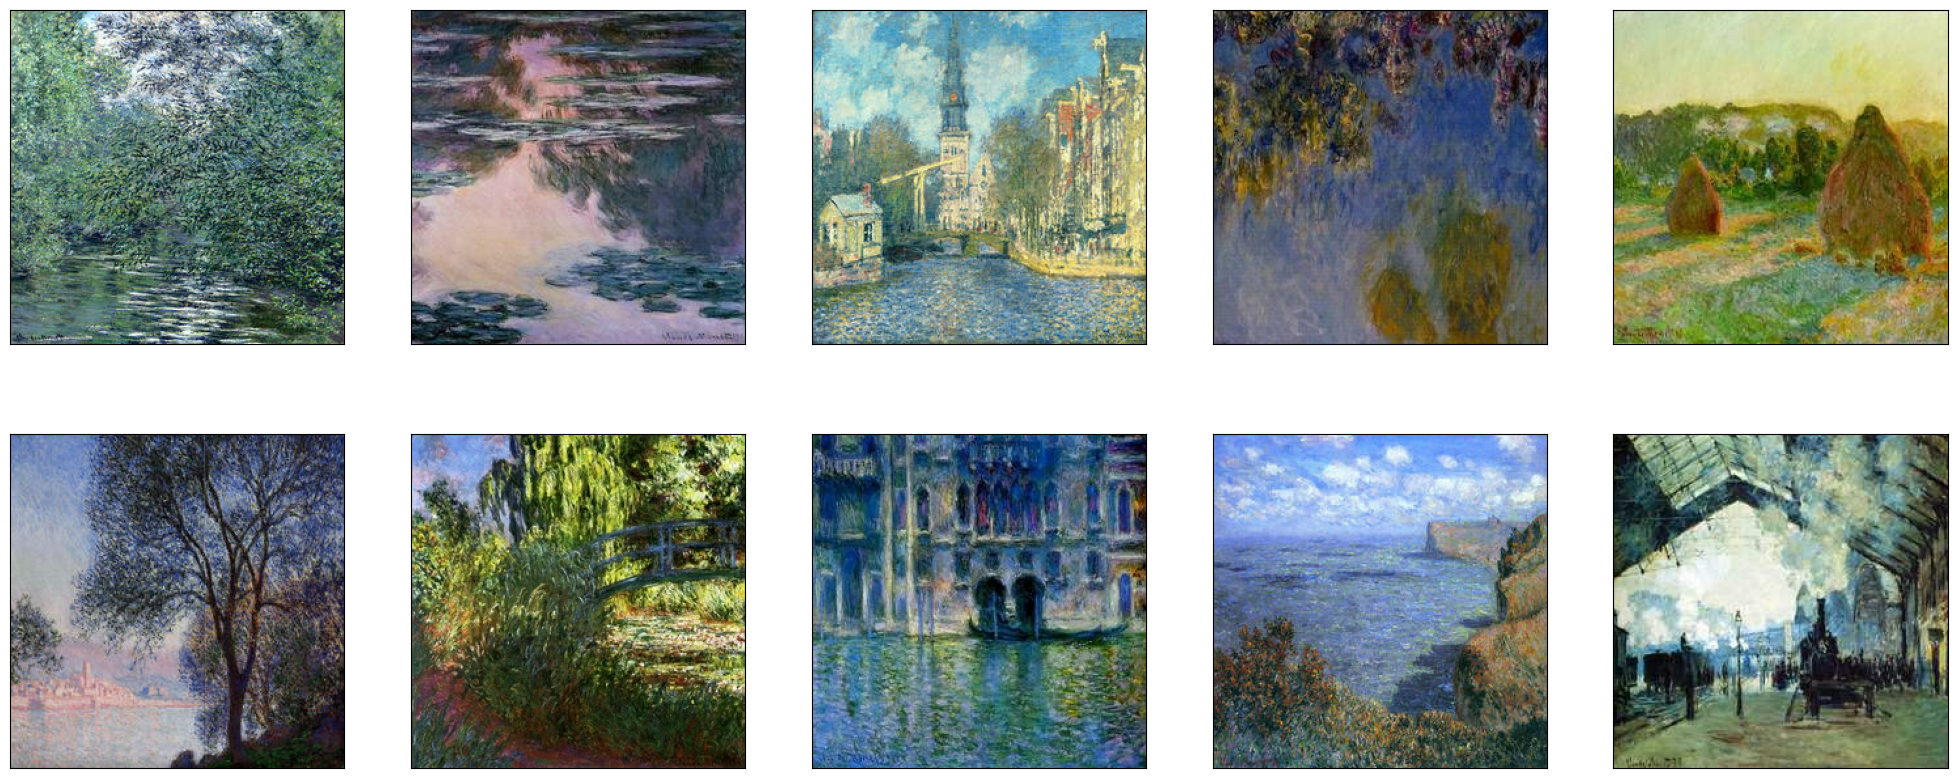

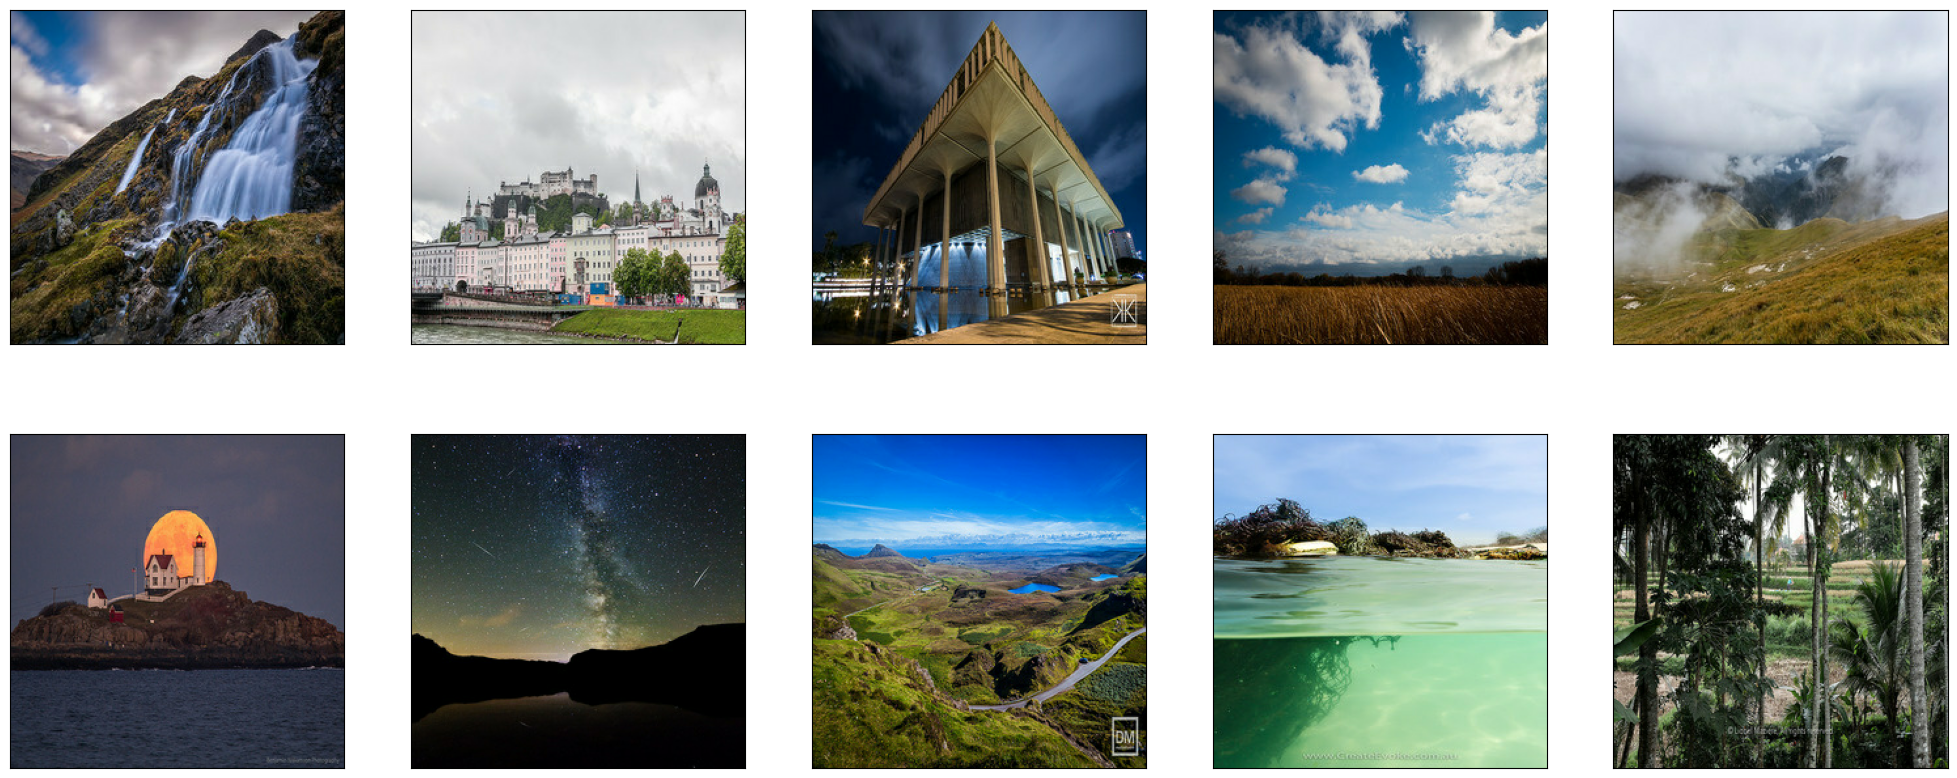

In [19]:
# display sample images
def view_image(ds, nrows=1, ncols=5):
    ds_iter = iter(ds)
    fig = plt.figure(figsize=(25, nrows * 5.05 ))

    for i in range(ncols * nrows):
        image = next(ds_iter)
        image = image.numpy()
        ax = fig.add_subplot(nrows, ncols, i+1, xticks=[], yticks=[])
        ax.imshow(image[0] * 0.5 + .5) # rescale the data in [0, 1] for display

view_image(monet_ds,2, 5)
view_image(photo_ds,2, 5)

<b>Model Architecture (CycleGAN)</b><br>
Inspiried by: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
    

In [ ]:
OUTPUT_CHANNELS = 3

# downsampling block for the generator, which consists of a convolutional layer followed by a leaky ReLU activation function
# the block reduces the spatial dimensions of the input image, while increasing the number of channels, which helps the generator learn complex patterns
def downsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    result.add(layers.LeakyReLU())

    return result

In [ ]:
# upsampling block for the generator, which consists of a transposed convolutional layer followed by a ReLU activation function
# the block increases the spatial dimensions of the input image, while reducing the number of channels, which helps the generator create realistic images
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())

    return result

In [ ]:
'''
The generator consists of a series of downsampling and upsampling blocks, which help the generator learn patterns and create images.
It takes an input image and generates a transformed image using instance normalization to normalize the activations of each layer, 
which helps the generator learn more quickly and generate more realistic images
the generator uses a tanh activation function to ensure the pixel values of the generated image are in the range [-1, 1]
'''

def Generator():
    inputs = layers.Input(shape=[256,256,3])
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (128, 128, 64)
        downsample(128, 4), # (64, 64, 128)
        downsample(256, 4), # (32, 32, 256)
        downsample(512, 4), # (16, 16, 512)
        downsample(512, 4), # (8, 8, 512)
        downsample(512, 4), # (4, 4, 512)
        downsample(512, 4), # (2, 2, 512)
        downsample(512, 4), # (1, 1, 512)
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (8, 8, 1024)
        upsample(512, 4), # (16, 16, 1024)
        upsample(256, 4), # (32, 32, 512)
        upsample(128, 4), # (64, 64, 256)
        upsample(64, 4), # (28, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (256, 256, 3)

    x = inputs
    skips = []
    # downsample through the model
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    # upsample and establish the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [ ]:
'''
The discriminator consists of a series of downsampling blocks, which help the discriminator learn patterns and classify images as real or fake.
It takes an input image and classifies it as real or fake using instance normalization to normalize the activations of each layer, 
where higher values indicate a real image and lower values indicate a fake image
'''
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp
    down1 = downsample(64, 4, False)(x) # (128, 128, 64)
    down2 = downsample(128, 4)(down1) # (64, 64, 128)
    down3 = downsample(256, 4)(down2) # (32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (31, 31, 512)

    leaky_relu = layers.LeakyReLU()(conv)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (33, 33, 512)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos
    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [ ]:
'''
CycleGAN consists of two generators and two discriminators, which help the model learn to transform images from one domain to another.
Generators transform images from one domain to another and the discriminators classify images as real or fake.
The model uses the cycle consistency loss to ensure that the generated images are similar to the original images, and the identity loss to ensure that the generated images are similar to the original images.
Generator loss is used to evaluate the performance of the generators and the discriminator loss to evaluate the performance of the discriminators.
The model uses the total generator loss to evaluate the performance of the generators and the total discriminator loss to evaluate the performance of the discriminators.
'''
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        # initialize the CycleGan model with the provided generators, discriminators, and cycle loss weight
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    # compile the model with the provided optimizers and loss functions
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    # train the model with the provided batch data and return the generator and discriminator losses
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


In [ ]:
# the discriminator loss outputs the average of the real (1) and generated loss(0)
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    # Generator loss
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)

# cycle consistency loss measures if original photo and the twice transformed photo to be similar to one another
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
            return LAMBDA * loss1

# identity loss compares the image with its generator 
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss


In [ ]:
# optimizers for the generators and discriminators (Adam optimizer with a learning rate of 2e-4 and beta_1=0.5)
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
# compile the model with the loss functions and optimizers
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator,
        monet_discriminator, photo_discriminator
    )
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )


In [ ]:
# train the CycleGAN
cycle_gan_model.fit(full_dataset, epochs=EPOCHS_NUM, steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE),)

Epoch 1/10
1759/1759 [==============================] - 335s 157ms/step - monet_gen_loss: 3.3465 - photo_gen_loss: 3.2067 - monet_disc_loss: 0.6362 - photo_disc_loss: 0.6449
Epoch 2/10
1759/1759 [==============================] - 276s 157ms/step - monet_gen_loss: 2.4094 - photo_gen_loss: 2.3646 - monet_disc_loss: 0.6406 - photo_disc_loss: 0.6177
Epoch 3/10
1759/1759 [==============================] - 276s 157ms/step - monet_gen_loss: 2.1878 - photo_gen_loss: 2.1652 - monet_disc_loss: 0.6339 - photo_disc_loss: 0.6097
Epoch 4/10
1759/1759 [==============================] - 275s 156ms/step - monet_gen_loss: 2.0441 - photo_gen_loss: 2.0460 - monet_disc_loss: 0.6311 - photo_disc_loss: 0.6085
Epoch 5/10
1759/1759 [==============================] - 275s 156ms/step - monet_gen_loss: 1.9971 - photo_gen_loss: 1.9740 - monet_disc_loss: 0.6212 - photo_disc_loss: 0.6037
Epoch 6/10
1759/1759 [==============================] - 276s 157ms/step - monet_gen_loss: 1.9537 - photo_gen_loss: 1.9640 - monet_

<b>Results, Analysis and Conclusion </b><br><br>
Unfortunately, the results are disappointing. Computer vision tasks require good hardware, so I naturally resorted to Google's Colab platform instead of training on my laptop. Although it sped up the training process, acces to free tier TPU's is not guaranteed 24/7 and my runtime got disconnected multiple times when training with higher epochs. Most I've managed to run was around 20, the photos were looking pretty Monet-esque but creating a submission file resulted in yet another timeout so my final version is this, 10 epochs and at least some resemblance of Monet. Had I started this project earlier, I might've had more time to save/load the semi-trained models and continue the training whenever TPU's were available.<br>
Enjoy the results and thanks for reviewing my notebook! 

In [ ]:
# show the generated images
def show_results(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        plt.subplot(121)
        plt.title("Input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

1/1 [==============================] - 6s 6s/step


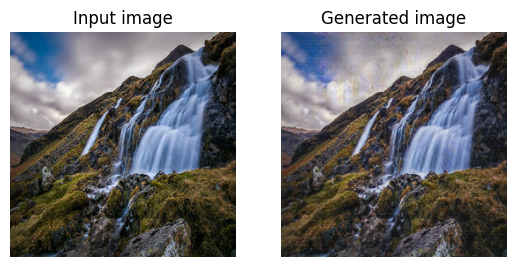

1/1 [==============================] - 1s 1s/step


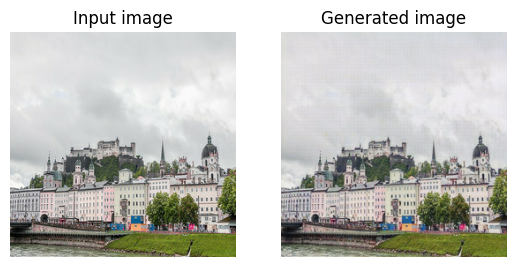

1/1 [==============================] - 0s 423ms/step


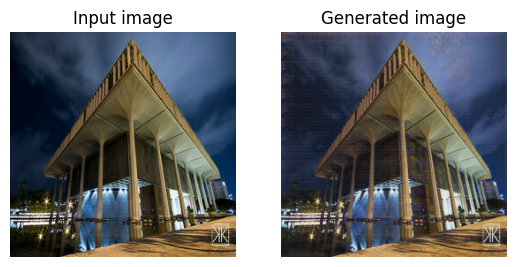

1/1 [==============================] - 0s 443ms/step


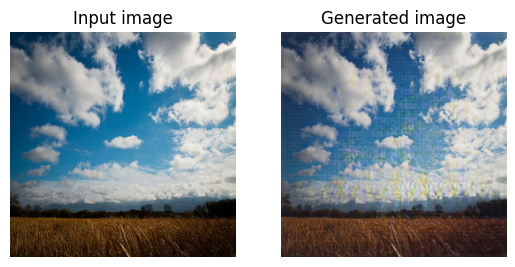

1/1 [==============================] - 0s 429ms/step


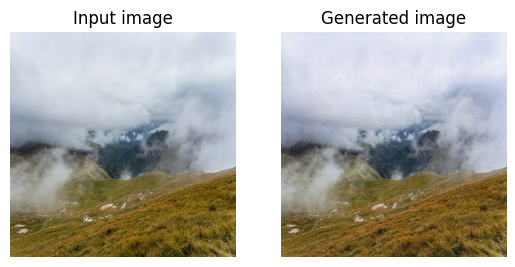

1/1 [==============================] - 0s 453ms/step


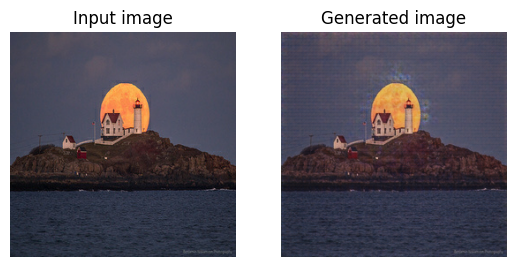

1/1 [==============================] - 1s 914ms/step


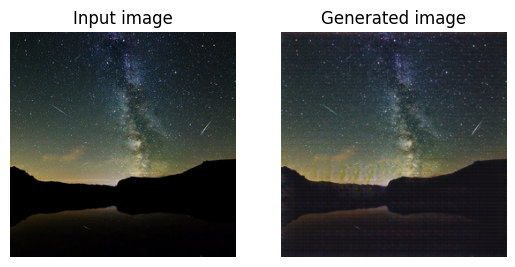

In [ ]:
show_results(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, 7)